# Fish Image Classification
  
This notebook aims to use a Convolutional Neural Network to try and correctly classify various species of Australian fish in images obtained from underwater videos.  
The original OzFish dataset used in this project has over 80,823 images of fish derived from Baited Underwater Video Stations, featuring 496 different species of Australian fish.

### Import Packages

In [1]:
import os 
from os import listdir # Used for acquiring filenames in image folder
import pandas as pd
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa # For focal loss function
from tensorflow import keras
from tensorflow.keras import models, layers
from sklearn.metrics import classification_report # For classification report

### Fix Files

All downloaded files came with a naming error, resulting in the wrong png extension, for example: '.png-27871'.  
All files should be converted back into a regular .png extension:

In [ ]:
for image_file in listdir('crops'):
    split = image_file.split('.png')
    os.rename('crops/' + image_file, 'crops/' + split[0] + '.png') 

### Preprocess and Clean Dataset

The OzFish dataset provides an associated metadata file for the images, containing information such as species, family and genus for each identified fish.  
We'll combine the metadata and the filepaths for each image in one dataframe:

In [2]:
metadata = pd.read_csv('crop_metadata.csv', index_col = 0)
metadata['file_name'] = 'crops/' + metadata['file_name'].astype(str) # Add filepath to each filename
metadata.head()

,file_name,family,genus,species
uid,,,,
1,crops/A000001_L.avi.5107.806.371.922.448.png,Scaridae,Chlorurus,capistratoides
2,crops/A000001_R.avi.4902.1388.355.1508.435.png,Scaridae,Chlorurus,capistratoides
3,crops/A000001_L.avi.5174.912.280.994.335.png,Scaridae,Chlorurus,capistratoides
4,crops/A000001_R.avi.4969.1600.255.1682.310.png,Scaridae,Chlorurus,capistratoides
5,crops/A000001_L.avi.5194.811.472.979.584.png,Acanthuridae,Acanthurus,leucocheilus


In [3]:
metadata['species'].nunique()

496

In [4]:
metadata['species'].value_counts()

punctulatus    6095
digramma       3172
atkinsoni      2635
sebae          2338
lutescens      2007
               ... 
nigripinnis       2
octotaenia        2
tiere             2
taeniatus         2
valentini         2
Name: species, Length: 496, dtype: int64

We can see that there is quite a substantial class imbalance in this dataset; the most frequent class consisting of 6095 images while the least frequent class consisting of only 2. It may be ideal to simply remove species that have too few images as they would otherwise have a considerable impact on the model's performance.  
  
We'll set a threshold for classes needing at least 105 images to be included in training and testing the model.

In [5]:
freq = pd.DataFrame(metadata['species'].value_counts()) # Dataframe containing species counts
freq.reset_index(inplace = True)
freq.rename(columns = {'index': 'Species', 'species': 'Count'}, inplace = True)

i = 0
for element in freq['Count']:
    if element < 105:
        i += 1
print('There are ' + str(i) + ' species that have less than 105 samples')

There are 344 species that have less than 105 samples


We'll now remove the classes with less than 105 samples:

In [6]:
filtered = [] # Contains species with > 105 samples
for i in range(len(freq)):
    if freq['Count'][i] > 105:
        filtered.append(freq['Species'][i])
        
cols = ['file_name', 'species']
fish = metadata[cols] # Remove unnecessary columns
fish = fish[fish['species'].isin(filtered)] # Filter species
fish = fish.sample(frac=1).reset_index(drop = True) # Shuffle images
fish.to_csv('ozfish_clean_dataset') # Save to csv

In [7]:
fish['species'].nunique()

151

In [8]:
fish.head()

,file_name,species
0,crops/G000369_R.avi.81707.1248.165.1549.365.png,punctulatus
1,crops/G000400_L.avi.20650.701.294.959.466.png,punctulatus
2,crops/G000153_L.avi.48867.682.488.909.639.png,lutescens
3,crops/A000045_L.avi.30089.568.96.724.200.png,niger
4,crops/E000519_R.MP4.31526.249.174.665.451.png,sebae


In [9]:
fish.shape

(71491, 2)

We're now left with 66,212 images and 158 unique classes.  

To gain a better understanding of what our data looks like, we'll sample a few images and display them:

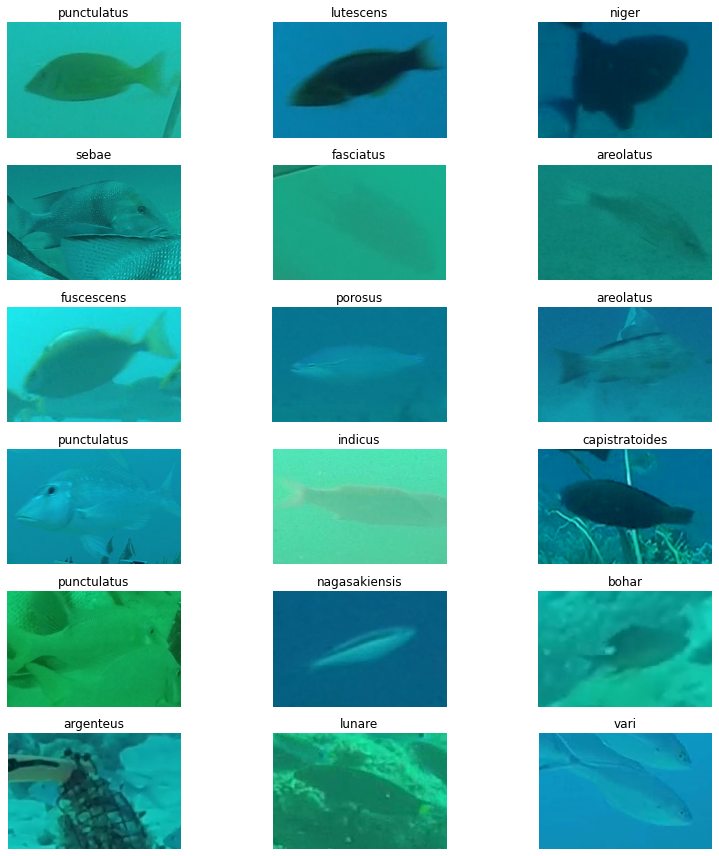

In [10]:
def load_images(df):
    rows = 6
    columns = 3
    fig = plt.figure(figsize=(12,12))
    for i in range(1, rows*columns+1):
        fig.add_subplot(rows,columns,i)
        plt.axis("off")
        plt.title(df['species'][i])
        plt.imshow(plt.imread(df['file_name'][i]))
    plt.tight_layout()
    plt.show()
    
load_images(fish)

Looking at the samples displayed above, we can see there is some disparity in the clarity of the images. Some fish are quite clearly presented in the image, while some are much harder to see. There are many photos in the dataset where irrelevant objects (such as pipes or coral) are covering parts of the fish, and even photos that contain multiple, overlapping fish. These will undoubtedly have an impact on the model's performance, but filtering out these images would be beyond the scope of this project so they'll be left as they are.

### Splitting Data

The data will be split into 70% for training, 20% for testing and 10% for validation.

In [11]:
train, test = train_test_split(fish, train_size = 0.8, random_state = 22)
train, valid = train_test_split(train, test_size = 0.1, random_state = 22) # Sample 10% validation data from training data

In [12]:
train.shape

(51472, 2)

In [13]:
test.shape

(14299, 2)

In [14]:
valid.shape

(5720, 2)

### Data Augmentation

As some species in the training dataset may have relatively few images, it may be necessary to generate more samples via data augmentation. This will give the model a larger number of samples for each species to train with.  
We'll apply the following augmentations:  
- Randomly rotated +- 5 degrees  
- Shift vertically by factor of 0.1  
- Shift horizontally by factor of 0.1  
- Sheared by factor of 0.1
- Randomly zoom in range [0.9, 1.1]
- Points outside boundaries filled based on nearest point
- Rescale image with 1/255 factor

In [15]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 5,
                                                                  width_shift_range = 0.1,
                                                                  height_shift_range = 0.1,
                                                                  shear_range = 0.1,
                                                                  zoom_range = 0.1,
                                                                  horizontal_flip = True,
                                                                  fill_mode = 'nearest',
                                                                  rescale = 1./255)
                                                                 
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255) # Test data only rescaled

train_img = train_generator.flow_from_dataframe(
    dataframe = train,
    x_col = 'file_name',
    y_col = 'species',
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 22
)

val_img = train_generator.flow_from_dataframe(
    dataframe = valid,
    x_col = 'file_name',
    y_col = 'species',
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 22
)

test_img = test_generator.flow_from_dataframe(
    dataframe = test,
    x_col = 'file_name', 
    y_col = 'species',
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)
    

Found 51472 validated image filenames belonging to 151 classes.
Found 5720 validated image filenames belonging to 151 classes.
Found 14299 validated image filenames belonging to 151 classes.


### Creating the CNN Architecture

Taking inspiration from the MiniVGGNet implementation, we'll begin designing the architecture for the CNN: 

In [16]:
num_classes = fish['species'].nunique()

In [17]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = (128, 128, 3)))
cnn_model.add(layers.BatchNormalization(momentum = 0.9))
cnn_model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(layers.BatchNormalization(momentum = 0.9))
cnn_model.add(layers.MaxPool2D(pool_size = (2,2)))


cnn_model.add(layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(layers.BatchNormalization(momentum = 0.9))
cnn_model.add(layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(layers.MaxPool2D(pool_size = (2,2)))


cnn_model.add(layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(layers.BatchNormalization(momentum = 0.9))
cnn_model.add(layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(layers.MaxPool2D(pool_size = (2,2)))
cnn_model.add(layers.Dropout(rate = 0.5))

cnn_model.add(layers.Conv2D(256, (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(layers.BatchNormalization(momentum = 0.9))
cnn_model.add(layers.Conv2D(256, (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(layers.MaxPool2D(pool_size = (2,2)))


cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(512, activation = 'relu'))
cnn_model.add(layers.BatchNormalization(momentum = 0.9))
cnn_model.add(layers.Dropout(rate = 0.5))
cnn_model.add(layers.Dense(num_classes, activation = 'softmax'))

In [18]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        2

### Compiling and Training the CNN

Now that the model's architecture has been created, it's time to compile the model and begin training.  
The focal loss function was used as it performs quite well with datasets containing a large class imbalance. We'll also use the Adam optimizer with a learning rate of 0.001.

In [19]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.001)
cnn_model.compile(optimizer = adam, loss = tfa.losses.SigmoidFocalCrossEntropy(), metrics = ['accuracy'])

history = cnn_model.fit(
    train_img, batch_size = 32,
    epochs = 70,
    validation_data = val_img,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 8, # Stop after 8 epochs if validation loss does not increase
            restore_best_weights = True
        )
    ]
)                   

Epoch 1/70
1609/1609 [==============================] - 203s 123ms/step - loss: 0.9463 - accuracy: 0.1583 - val_loss: 0.7987 - val_accuracy: 0.2154
Epoch 2/70
1609/1609 [==============================] - 195s 121ms/step - loss: 0.7545 - accuracy: 0.2469 - val_loss: 0.6597 - val_accuracy: 0.3301
Epoch 3/70
1609/1609 [==============================] - 195s 121ms/step - loss: 0.6442 - accuracy: 0.3204 - val_loss: 0.5952 - val_accuracy: 0.3741
Epoch 4/70
1609/1609 [==============================] - 196s 122ms/step - loss: 0.5612 - accuracy: 0.3868 - val_loss: 0.5683 - val_accuracy: 0.4353
Epoch 5/70
1609/1609 [==============================] - 197s 122ms/step - loss: 0.5066 - accuracy: 0.4348 - val_loss: 0.4681 - val_accuracy: 0.4916
Epoch 6/70
1609/1609 [==============================] - 197s 122ms/step - loss: 0.4646 - accuracy: 0.4730 - val_loss: 0.4384 - val_accuracy: 0.5150
Epoch 7/70
1609/1609 [==============================] - 196s 122ms/step - loss: 0.4303 - accuracy: 0.5042 - val_

1609/1609 [==============================] - 198s 123ms/step - loss: 0.1297 - accuracy: 0.8235 - val_loss: 0.1868 - val_accuracy: 0.7823
Epoch 57/70
1609/1609 [==============================] - 204s 127ms/step - loss: 0.1295 - accuracy: 0.8242 - val_loss: 0.1948 - val_accuracy: 0.7743
Epoch 58/70
1609/1609 [==============================] - 203s 126ms/step - loss: 0.1292 - accuracy: 0.8252 - val_loss: 0.1808 - val_accuracy: 0.7927
Epoch 59/70
1609/1609 [==============================] - 202s 125ms/step - loss: 0.1269 - accuracy: 0.8279 - val_loss: 0.1996 - val_accuracy: 0.7740
Epoch 60/70
1609/1609 [==============================] - 218s 136ms/step - loss: 0.1263 - accuracy: 0.8277 - val_loss: 0.1748 - val_accuracy: 0.8054


### Evaluate Model Training

To see how well the model learned throughout each epoch, we'll create a few plots that highlight its accuracy and loss during training:

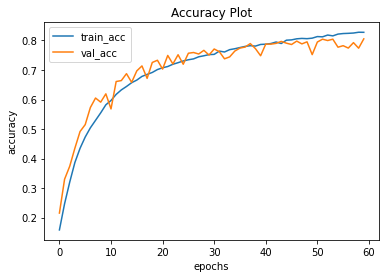

In [20]:
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title('Accuracy Plot')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

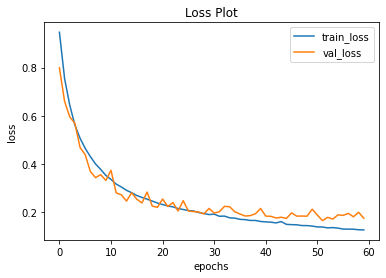

In [21]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title('Loss Plot')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

### Model Results and Performance

In order to see how well our model performs, we'll use it to predict the classes of all the images in the testing dataset:

In [22]:
result = cnn_model.evaluate(test_img)
print('Test Loss: {:.5f}'.format(result[0]))
print('Test Accuracy: {:.2f}%'.format(result[1] * 100))

447/447 [==============================] - 21s 46ms/step - loss: 0.1451 - accuracy: 0.8302
Test Loss: 0.14505
Test Accuracy: 83.02%


In [23]:
# Create array containing predicted labels for each image in the test set
pred_test = cnn_model.predict(test_img) # Dataframe containing label predictions of each image
pred_test = np.argmax(pred_test, axis = 1,) # Get the row indexes of the most likely labels for each image
labs = dict((x,y) for y,x in train_img.class_indices.items()) # Reverse key:value positions in dictionary
pred_test = [labs[i] for i in pred_test]
actual = list(test['species']) # Get true labels
print(classification_report(actual, pred_test))

                  precision    recall  f1-score   support

       aculeatus       0.92      0.92      0.92        13
   albimarginata       0.64      0.58      0.61        24
   amblycephalum       0.85      0.65      0.73       110
   amblyrhynchos       0.87      0.90      0.88        50
     amboinensis       0.53      0.50      0.51        38
       annulatus       0.60      0.56      0.58       114
       areolatus       0.81      0.87      0.84       208
       argenteus       0.73      0.83      0.78       135
           argus       0.44      0.58      0.50        19
         aruanus       0.92      0.97      0.94        35
        assarius       0.73      0.93      0.81        40
       atkinsoni       0.93      0.88      0.91       551
  atripectoralis       0.88      0.78      0.82        27
          auriga       0.97      0.93      0.95        73
          aygula       0.65      0.56      0.60        55
     bandanensis       0.45      0.20      0.28        25
   barberinoi

In [24]:
cnn_model.save('ozfish_cnn2') # Save the model

INFO:tensorflow:Assets written to: ozfish_cnn2\assets


In [25]:
pickle.dump(labs, open('ozfish_labels2.pkl', 'wb'))